In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD, NMF
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, WhitespaceTokenizer, \
                          RegexpTokenizer, sent_tokenize, MWETokenizer
from nltk.util import ngrams
from nltk.chunk import ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import gensim
import warnings
import logging
import pickle

%matplotlib inline
pd.options.display.max_columns = 100

In [2]:
def get_sim_from_review_word2vec(word):
    try:
        return gensim_model.most_similar(word.lower())
    except Exception as e:
        return e

In [3]:
# this code doesn't work anymore after upgrading to pandas 0.20.1,
# will get ModuleNotFoundError: No module named 'pandas.indexes'
# with open("cleaned_data.pkl", 'rb') as picklefile: 
#     book_review = pickle.load(picklefile)
book_review = pd.read_pickle("cleaned_w_bknlp.pkl")

In [4]:
book_review.tail(1)

,bookid,review_like_ct,review_rating,review_desc,userid,review_date,review_yr,review_mon,review_wday_num,review_d_since_1streview,bk_author,bk_avg_rating,bk_desc,bk_n_ratings,bk_n_text_reviews,bk_page_ct,bk_pub_yr,bk_title,user_tot_reviews,dup_ind,bk_desc_len,review_desc_len,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6,bk_latent7,bk_latent8,bk_latent9,bk_latent10,bk_latent11,bk_latent12,bk_latent13,bk_latent14,bk_latent15,bk_latent16,bk_latent17,bk_latent18,bk_latent19,bk_latent20,bk_latent21,bk_latent22,bk_latent23,bk_latent24,bk_compound,bk_neg,bk_neu,bk_pos
19230,17261174,1,5,"Utterly charming, well paced, written and draw...",1722508,2016-09-23,2016,9,5,1177.0,Tony Cliff,3.94,"A little bit Tintin, a little bit Indiana Jone...",5828,642,122.0,2013.0,Delilah Dirk and the Turkish Lieutenant,1,0.0,169,234,0.012278,0.009694,0.002747,-0.004424,-0.003759,-0.013886,0.022413,-0.014292,0.021448,0.027383,0.014106,-0.037387,0.004757,-0.031679,-0.046127,0.020205,0.014026,-0.01537,-0.019088,-0.029996,-0.032688,-0.034501,-0.066593,0.016079,0.018705,-0.4404,0.185,0.726,0.089


In [5]:
cond = book_review['review_desc_len'] == 0
review_coll = book_review.loc[~cond, ['bookid', 'userid', 'review_desc']].drop_duplicates()
review_coll.set_index(['bookid', 'userid'], inplace = True)

In [6]:
review_coll.tail(1)

,,review_desc
bookid,userid,
17261174,1722508,"Utterly charming, well paced, written and draw..."


In [7]:
row_order = review_coll.index

### sentiment by sentence

In [475]:
sid_df = review_coll.copy()

In [476]:
sid = SentimentIntensityAnalyzer()

In [477]:
sid_df['dict'] = sid_df["review_desc"].map(sid.polarity_scores)
sid_df = pd.concat([sid_df.drop(['dict'], axis=1), sid_df['dict'].apply(pd.Series)], axis=1)
sid_df.tail(1)

,,review_desc,compound,neg,neu,pos
bookid,userid,,,,,
17261174,1722508,"Utterly charming, well paced, written and draw...",0.5678,0.104,0.688,0.208


In [482]:
sid_df = sid_df.drop(['review_desc'], axis=1)
sid_df.columns = 'sentiment_' + pd.Series(sid_df.columns)
sid_df.tail(1)

,,sentiment_compound,sentiment_neg,sentiment_neu,sentiment_pos
bookid,userid,,,,
17261174,1722508,0.5678,0.104,0.688,0.208


### preprocessing

In [8]:
review_coll['tokens'] = review_coll["review_desc"].map(lambda x: word_tokenize(x))
review_coll.tail(1)

,,review_desc,tokens
bookid,userid,,
17261174,1722508,"Utterly charming, well paced, written and draw...","[Utterly, charming, ,, well, paced, ,, written..."


In [9]:
# cutoff non-English words
words = set(nltk.corpus.words.words())
review_coll['tokens'] = review_coll["tokens"].map(lambda x: [y for y in x if y in words])

In [10]:
stemmer = LancasterStemmer()
review_coll['stemmed'] = review_coll["tokens"].map(lambda x: " ".join([stemmer.stem(y) for y in x]))
review_coll.tail(1)

,,review_desc,tokens,stemmed
bookid,userid,,,
17261174,1722508,"Utterly charming, well paced, written and draw...","[charming, well, paced, written, and, drawn, a...",charm wel pac writ and drawn also mak for a go...


### sentiment - wrong

In [440]:
# sid = SentimentIntensityAnalyzer()

In [443]:
# sid_df = review_coll.copy()
# sid_df.tail(1)

,,review_desc,tokens
bookid,userid,,
17261174,1722508,"Utterly charming, well paced, written and draw...","[Utterly, charming, ,, well, paced, ,, written..."


In [478]:

# #sid_df['dict'] = 
# sid_df["tokens"].map(sid.polarity_scores)
# # sid_df = pd.concat([sid_df.drop(['dict'], axis=1), sid_df['dict'].apply(pd.Series)], axis=1)
# # sid_df.tail(1)

In [425]:
# sid_df = sid_df.drop(['review_desc', 'tokens', 'stemmed'], axis = 1)
# sid_df.reset_index(inplace = True)
# sid_df.tail(1)

,bookid,userid,compound,neg,neu,pos
19216,17261174,1722508,0.6808,0.0,0.828,0.172


### more preprocessing

In [11]:
cv = TfidfVectorizer(strip_accents = 'unicode' 
                     , ngram_range = (1, 2)
                     , stop_words = "english"
                     , max_df = 0.5
                     , min_df = 10 # TODO raise this?
                     , norm = 'l2' # important to normalize?
                     )
review_coll = cv.fit_transform(review_coll['stemmed'])
review_coll = pd.DataFrame(review_coll.todense(), columns=[cv.get_feature_names()])
review_coll.tail(1)

,aaron,ab,ab lincoln,aback,abandon,abduc,abid,abigail,abl,abl apprecy,abl bring,abl chang,abl complet,abl connect,abl control,abl cre,abl enjoy,abl feel,abl fig,abl fin,abl follow,abl giv,abl guess,abl hav,abl help,abl just,abl liv,abl look,abl lov,abl mak,abl mov,abl pick,abl predict,abl pul,abl read,abl real,abl rememb,abl stand,abl stop,abl surv,abl tak,abl tel,abl thi,abl think,abl travel,abl turn,abl understand,abl weav,abl work,abl writ,...,young boy,young broth,young child,young fem,young girl,young hav,young hero,young heroin,young jew,young lady,young lov,young man,young men,young old,young peopl,young print,young read,young self,young sist,young son,young teen,young thi,young wer,young wil,young wom,young young,yourselv,youth,yummy,za,za se,zach,zam,zany,zeal,zek,zero,zeu,zomby,zomby act,zomby apocalyps,zomby book,zomby fict,zomby genr,zomby novel,zomby outbreak,zomby story,zomby vir,zomby war,zon
19216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### get word2vec - correct

In [70]:
corpus = pd.read_pickle("cleaned_w_bknlp.pkl")
corpus = corpus[['review_desc']]
corpus.tail(1)

,review_desc
19230,"Utterly charming, well paced, written and draw..."


In [118]:
class MySentences2(object):
#      def __init__(self, dirname):
#             self.dirname = dirname
 
     def __iter__(self):
#          for fname in os.listdir(self.dirname):
#                 for line in open(os.path.join(self.dirname, fname)):
#                     word=line.lower().split()
#                     if word not in stop:
#                         yield word
        for row in range(corpus.shape[0]):
            txt = re.sub("[^a-z ]*", "", corpus.iloc[row, 0].lower()).strip(" ")
            txt_li = [x for x in txt.split(" ") if x != ""]
            # txt_li = [x for x in txt_li if x in words] # DON'T USE; GOT RID OF TOO MANY ENTITY NAMES
            yield txt_li

In [119]:
gensim_model = gensim.models.Word2Vec(MySentences2(), 
                                      seed = 0,
                                      window = 5,
                                      size = 100, # np.sqrt(len(gensim_input)),
                                      min_count = 6,
                                      sg = 1,
                                      iter = 5
                                     ) # TODO tune params

- get similarity

In [183]:
pick_me = "lovecraft"
stuff = pd.DataFrame(get_sim_from_review_word2vec(pick_me)) #neil, tim, fantasy
stuff.set_index(0, inplace = True)
stuff.columns = ["cos_sim"]
stuff = stuff.append(pd.DataFrame({"cos_sim": [1]}, index = [pick_me]))
stuff

,cos_sim
hp,0.767199
tolkien,0.752905
poe,0.746972
jules,0.735068
doyles,0.718797
shakespeare,0.718397
narnia,0.709318
verne,0.705937
gentlemen,0.704869
neverwhere,0.704498


- plot word in latent vector space (using first two vectors)

In [184]:
wv_df = dict()
for key, val in gensim_model.wv.vocab.items():
        wv_df[key] = gensim_model.wv[key]
wv_df = pd.DataFrame(wv_df).transpose()
wv_df.tail(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
zurck,0.004968,0.076924,-0.165460,0.123321,-0.661399,0.122611,-0.192759,0.119749,-0.134442,-0.272311,0.243164,-0.038938,-0.015278,-0.511606,0.077258,-0.212321,0.310730,-0.194718,0.002141,-0.510400,-0.038517,0.042945,-0.220324,-0.143439,-0.114450,0.109286,-0.115239,-0.026714,0.134832,-0.038651,0.007384,0.085361,0.367866,-0.144578,0.233810,0.226460,-0.025481,-0.118437,-0.005876,-0.263882,0.031922,0.651791,0.121167,0.168005,0.365964,0.353307,-0.025292,-0.209312,-0.183819,0.015216,-0.026274,-0.449481,0.053676,-0.212848,0.329979,0.422707,0.045301,-0.300970,0.126184,0.001986,0.377009,0.017529,-0.412543,-0.287529,0.204826,0.594772,-0.090459,-0.047669,0.183138,0.444808,0.082609,0.223574,-0.076445,0.178934,0.248613,-0.335222,-0.410798,0.009471,0.025421,0.128730,0.036487,0.143512,0.221116,0.090943,0.231205,0.434015,0.163877,0.198442,0.261751,0.021570,-0.098872,-0.252333,-0.113386,0.157020,-0.059981,-0.326015,-0.347017,-0.352953,-0.334878,-0.171370
zusak,0.050930,0.134603,-0.167593,0.150116,-0.099363,-0.150582,-0.423170,-0.580293,0.058335,-0.121073,-0.214659,-0.125728,0.010926,0.188222,0.179532,-0.317611,0.031657,0.016979,0.414982,0.102645,-0.097016,0.050089,0.130540,0.054062,-0.250168,-0.107302,0.273761,0.049874,0.050866,0.062152,0.168241,-0.293039,0.101183,0.119459,-0.441132,0.144542,0.066142,-0.223477,0.026597,-0.256325,0.156832,0.130423,0.393325,-0.130749,0.420083,-0.180471,0.126945,0.255264,-0.118757,-0.182523,0.054261,-0.536701,-0.365430,0.067230,-0.373554,-0.004868,0.418758,0.076053,0.236646,-0.006359,0.460533,0.228432,-0.623640,-0.500814,0.327226,0.132367,0.029455,0.073399,0.378260,0.419635,0.164613,0.062164,-0.303281,0.022752,0.073839,-0.189879,0.254526,-0.097633,-0.145667,-0.062669,0.219294,-0.213060,0.179504,0.152475,0.005168,0.077869,0.043274,0.124789,0.258755,-0.362497,0.011060,0.311366,0.180408,-0.003633,-0.332396,0.090936,0.051697,0.003574,-0.040390,-0.110054
zusaks,-0.147393,0.095507,-0.089804,-0.018050,-0.071530,-0.014336,-0.297148,-0.430422,-0.097578,-0.208508,-0.064330,0.089739,-0.076956,0.087092,0.166862,-0.198419,0.039154,-0.116337,0.139000,0.054061,-0.182449,-0.076718,-0.085664,-0.063079,-0.334065,-0.089336,0.254224,0.078505,0.049692,-0.006327,0.192930,-0.219034,0.054105,0.048341,-0.083637,-0.091723,-0.156257,-0.211158,-0.157264,-0.220579,-0.179741,-0.016089,0.110719,-0.278073,0.239538,-0.018699,0.032451,0.311762,-0.078255,0.130376,0.044706,-0.459513,-0.249155,0.132181,0.015251,-0.060536,0.179668,0.011686,0.096699,0.094434,0.160256,-0.025755,-0.459708,-0.244187,0.258654,-0.025444,0.093974,0.114871,0.151180,0.344905,0.107823,-0.063882,-0.055605,0.042598,0.055241,-0.245821,-0.022263,-0.229524,-0.297463,0.004239,0.028802,-0.289418,0.167834,0.262622,0.091698,0.173287,0.108052,0.042463,0.186121,-0.261963,0.089481,-0.013709,0.064105,0.058036,-0.333430,0.068349,0.074895,0.012367,0.057064,-0.200969
zusammen,-0.019922,0.094669,-0.232868,0.147822,-0.789043,0.178046,-0.253320,0.153302,-0.166200,-0.325409,0.245642,0.041170,0.082647,-0.597435,0.047651,-0.382645,0.401239,-0.266777,0.011613,-0.548168,-0.058919,0.060398,-0.264808,-0.175628,-0.110073,0.164103,-0.123613,0.006711,0.225677,-0.102033,0.000962,0.064329,0.396639,-0.160586,0.256311,0.257078,-0.091553,-0.129862,0.010281,-0.260483,0.032866,0.805395,0.056660,0.161175,0.442704,0.505809,-0.170226,-0.232154,-0.274849,0.054761,-0.081979,-0.476782,-0.019528,-0.193288,0.318650,0.437021,0.057763,-0.413038,0.113326,0.047694,0.392845,-0.001228,-0.411817,-0.380631,0.195088,0.728474,-0.150922,-0.121163,0.208001,0.511359,0.158919,0.252881,-0.080157,0.233710,0.411245,-0.419490,-0.582277,0.010574,0.068980,0.172051,0.079714,0.101267,0.207804,0.168353,0.283758,0.582155,0.154608,0.288248,0.439473,0.008530,-

In [185]:
sim_words = stuff.merge(wv_df, how = "left", left_index = True, right_index = True)
sim_words.tail(1)

,cos_sim,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
lovecraft,1.0,-0.323002,-0.158848,0.120759,0.456668,-0.075098,-0.065365,-0.054407,-0.339385,-0.191451,0.002679,-0.24575,0.085603,0.079813,0.068849,0.405128,-0.354001,0.368045,0.070662,0.012091,-0.212562,-0.245416,-0.082711,0.345748,0.087359,0.095468,0.229746,0.483527,-0.215669,-0.089295,0.065086,-0.089211,-0.048113,0.062451,0.088866,0.049929,-0.110075,-0.332358,0.016495,-0.010866,-0.283124,-0.199169,0.337662,0.086861,-0.26627,0.284747,-0.226007,0.048369,-0.008714,0.107656,...,-0.328886,-0.68255,-0.124226,-0.01982,0.022514,0.333071,0.12584,0.065135,0.081787,-0.319764,0.403079,-0.264179,-0.331898,-0.0735,0.356423,0.224968,0.203005,0.338927,0.103807,0.456852,0.179122,0.156501,-0.234211,0.288837,0.034854,-0.070266,0.300127,-0.078337,0.217825,-0.549939,0.290521,0.006016,-0.052626,0.269417,-0.151632,-0.15469,0.108599,0.031099,0.257195,-0.30375,-0.281205,-0.375232,0.18304,0.241557,-0.290057,-0.108886,0.219893,0.209828,-0.11911,-0.118545


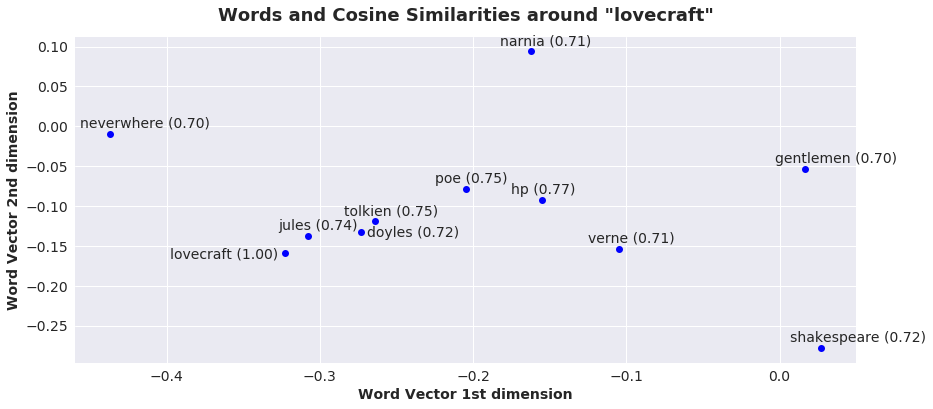

In [276]:
fig = plt.figure(figsize = (14, 6))
ax = fig.add_subplot(111)
a = sim_words.iloc[:, 1]
b = sim_words.iloc[:, 2]
c = sim_words.index
d = sim_words.iloc[:, 0]
plt.plot(a, b, "bo")
plt.xlabel("Word Vector 1st dimension", fontsize = 14, fontweight = "bold")
plt.ylabel("Word Vector 2nd dimension", fontsize = 14, fontweight = "bold")
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.title('Words and Cosine Similarities around "lovecraft"', fontsize = 18, y = 1.03, fontweight = "bold")
for tup in zip(a, b, c, d):   
    if tup[2] == 'doyles':
        ax.annotate(tup[2] + r" (" + str(format(round(float(tup[3]), 4), "4.2f")) + r")", xy = (tup[0] + 0.004, \
            tup[1] - 0.006), textcoords='data', fontsize = 14)   
    elif tup[2] == 'lovecraft':
        ax.annotate(tup[2] + r" (" + str(format(round(float(tup[3]), 4), "4.2f")) + r")", xy = (tup[0] - 0.075, \
            tup[1] - 0.006), textcoords='data', fontsize = 14) 
    else:
        ax.annotate(tup[2] + r" (" + str(format(round(float(tup[3]), 4), "4.2f")) + r")", xy = (tup[0] - 0.02, \
            tup[1] + 0.008), textcoords='data', fontsize = 14)

plt.show()

In [237]:
# fig = plt.figure(figsize = (8, 6))
# tot_words = wv_df.shape[0]
# n_words_to_plot = 50
# sample = range(5, tot_words, tot_words // n_words_to_plot)
# ax = fig.add_subplot(111)
# a = wv_df.iloc[sample, 0]
# b = wv_df.iloc[sample, 1]
# c = wv_df.index[sample]
# plt.plot(a, b, "bo")
# for tup in zip(a, b, c):                                      
#     ax.annotate(tup[2], xy = (tup[0] + 0.0001, tup[1] + 0.005), textcoords='data', fontsize = 14)
# plt.show()

### get word2vec - wrong

In [15]:
# barely works on Mac...
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [61]:
# review_coll.tail(1)

,,aaron,ab,ab lincoln,aback,abandon,abduc,abid,abigail,abl,abl apprecy,abl bring,abl chang,abl complet,abl connect,abl control,abl cre,abl enjoy,abl feel,abl fig,abl fin,abl follow,abl giv,abl guess,abl hav,abl help,abl just,abl liv,abl look,abl lov,abl mak,abl mov,abl pick,abl predict,abl pul,abl read,abl real,abl rememb,abl stand,abl stop,abl surv,abl tak,abl tel,abl thi,abl think,abl travel,abl turn,abl understand,abl weav,abl work,abl writ,...,young boy,young broth,young child,young fem,young girl,young hav,young hero,young heroin,young jew,young lady,young lov,young man,young men,young old,young peopl,young print,young read,young self,young sist,young son,young teen,young thi,young wer,young wil,young wom,young young,yourselv,youth,yummy,za,za se,zach,zam,zany,zeal,zek,zero,zeu,zomby,zomby act,zomby apocalyps,zomby book,zomby fict,zomby genr,zomby novel,zomby outbreak,zomby story,zomby vir,zomby war,zon
bookid,userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17261174,1722508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# gensim_input = list(review_coll.apply(lambda y: [x for x in review_coll.columns.where(y != 0) if type(x) == str], axis = 1))

In [17]:
# gensim_model = gensim.models.Word2Vec(gensim_input, 
#                                       seed = 0,
#                                       window = 5,
#                                       size = 100, # np.sqrt(len(gensim_input)),
#                                       min_count = 6,
#                                       sg = 1,
#                                       iter = 5
#                                      ) # TODO tune params

- get similarity

In [67]:
# get_sim_from_review_word2vec("horr") #neil, tim, fantasy

[('hot', 0.970855712890625),
 ('hor', 0.9696642160415649),
 ('hon', 0.9622901678085327),
 ('hous', 0.955142617225647),
 ('hors', 0.9544278979301453),
 ('humbl', 0.9521094560623169),
 ('hist novel', 0.948604166507721),
 ('howev', 0.9478734135627747),
 ('hopeless', 0.9459930658340454),
 ('hug', 0.9449830055236816)]

- plot word in latent vector space (using first two vectors)

In [19]:
# wv_df = dict()
# for key, val in gensim_model.wv.vocab.items():
#         wv_df[key] = gensim_model.wv[key]
# wv_df = pd.DataFrame(wv_df).transpose()
# wv_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
aaron,-0.141168,0.303166,-0.131583,0.346581,0.186734,0.124780,0.341111,-0.241829,-0.291805,-0.044339,0.172669,-0.108038,-0.208571,-0.007058,-0.193081,0.093780,0.010578,0.525366,-0.036902,-0.192273,-0.208899,0.245950,0.037230,-0.125875,0.081042,-0.064876,0.186713,-0.356630,0.326987,0.194633,0.169942,-0.052942,0.041166,0.089985,-0.019060,0.270884,-0.180742,-0.166346,-0.063208,-0.176158,-0.091913,0.525878,-0.188328,0.137943,-0.109427,-0.125173,-0.214150,0.179356,-0.065612,-0.045531,-0.292724,-0.007033,0.007840,0.087204,0.072696,0.046938,-0.155463,0.113800,0.001150,-0.043426,-0.085738,-0.097523,0.225261,-0.306066,-0.125450,-0.233493,-0.088713,-0.104667,-0.029263,-0.349115,0.102758,-0.144356,0.155434,0.083763,0.271779,0.142410,-0.139687,-0.070659,0.116063,-0.204227,-0.034744,-0.141695,0.174075,0.110327,-0.233808,-0.043208,-0.098561,-0.099315,0.216296,-0.404217,0.365018,-0.120904,0.125031,-0.020182,-0.253857,0.068294,-0.174542,-0.073799,0.053454,0.290085
ab,-0.174191,0.421246,-0.173311,0.473002,0.268769,0.203982,0.468061,-0.356595,-0.444435,-0.120449,0.225652,-0.193208,-0.329613,0.092716,-0.251193,0.117480,0.071705,0.730016,-0.097720,-0.255948,-0.268831,0.381074,0.072808,-0.237856,0.059473,-0.016842,0.324020,-0.454310,0.424571,0.268679,0.240365,-0.047311,0.032540,0.056727,0.003011,0.357969,-0.220739,-0.261526,-0.012062,-0.301806,-0.141143,0.786846,-0.251401,0.096432,-0.138405,-0.104873,-0.305481,0.322983,-0.129148,-0.006617,-0.444575,-0.043633,0.008846,0.134062,0.082923,0.020141,-0.256807,0.159590,-0.035159,-0.020511,0.011025,-0.192321,0.306956,-0.536945,-0.191210,-0.332238,-0.176764,-0.192956,-0.016408,-0.527471,0.207243,-0.129289,0.267275,0.107139,0.376259,0.131256,-0.165870,-0.034250,0.170142,-0.288750,-0.099859,-0.213341,0.275426,0.234990,-0.272033,-0.003612,-0.190378,-0.134499,0.369120,-0.572350,0.507366,-0.058220,0.158791,-0.084195,-0.349060,0.093527,-0.353457,-0.119670,0.082938,0.486012
ab lincoln,-0.148162,0.362698,-0.157179,0.380588,0.194290,0.168673,0.383967,-0.286801,-0.258036,-0.034243,0.198854,-0.155573,-0.249410,0.015777,-0.214099,0.101936,0.086468,0.570249,-0.057675,-0.259076,-0.200906,0.276575,0.072243,-0.124954,0.053451,-0.036617,0.214210,-0.355135,0.350649,0.167502,0.190679,-0.027372,0.015109,0.119423,-0.006310,0.301916,-0.206439,-0.265201,0.029774,-0.216068,-0.161844,0.599963,-0.119452,0.132642,-0.144541,-0.042350,-0.248993,0.194252,-0.030730,0.032492,-0.355560,-0.007594,0.029625,0.067286,0.014163,-0.003614,-0.181787,0.106413,0.016515,0.016404,-0.028785,-0.147127,0.267200,-0.397702,-0.141535,-0.262871,-0.094125,-0.155471,-0.059053,-0.339065,0.111442,-0.129218,0.195003,0.063344,0.371632,0.137062,-0.168692,-0.085766,0.128411,-0.149600,-0.087759,-0.181349,0.203168,0.112717,-0.296912,-0.052067,-0.086028,-0.107122,0.241764,-0.472622,0.433333,-0.109167,0.153124,-0.061513,-0.275322,0.046106,-0.204597,-0.092807,0.088642,0.308986
aback,-0.166288,0.370007,-0.131429,0.425729,0.152514,0.159578,0.404422,-0.290399,-0.286771,-0.059269,0.167217,-0.177645,-0.239705,0.032390,-0.214786,0.099016,0.047913,0.560533,-0.041400,-0.240841,-0.211023,0.215856,0.082580,-0.131160,0.043137,-0.035636,0.192729,-0.316822,0.344237,0.232937,0.223049,-0.035593,0.024664,0.141312,-0.011043,0.259073,-0.211944,-0.209362,-0.025045,-0.203817,-0.136308,0.592146,-0.205609,0.127032,-0.120072,-0.084154,-0.237858,0.189068,-0.073059,0.017285,-0.294254,-0.016770,-0.041666,0.109235,0.097708,0.018826,-0.188359,0.127767,0.024583,-0.026975,-0.060535,-0.126168,0.242527,-0.335236,-0.177882,-0.258042,-0.104852,-0.116835,-0.072098,-0.397148,0.113248,-0.148725,0.146677,0.105446,0.365686,0.152528,-0.180019,-0.044559,0.134779,-0.163856,-0.024866,-0.130273,0.231171,0.145845,-0.263707,-0.03

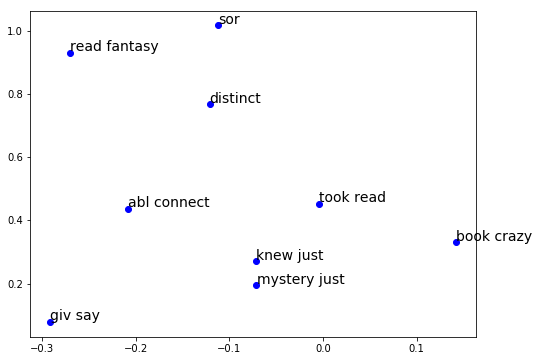

In [20]:
# fig = plt.figure(figsize = (8, 6))
# tot_words = wv_df.shape[0]
# n_words_to_plot = 9
# sample = range(13, tot_words, tot_words // n_words_to_plot)
# ax = fig.add_subplot(111)
# a = wv_df.iloc[sample, 0]
# b = wv_df.iloc[sample, 1]
# c = wv_df.index[sample]
# plt.plot(a, b, "bo")
# for tup in zip(a, b, c):                                      
#     ax.annotate(tup[2], xy = (tup[0] + 0.0001, tup[1] + 0.005), textcoords='data', fontsize = 14)
# plt.show()

### get latent features - PCA

In [ ]:
# init_n_components = 500 # min(review_coll.shape) - 1
# init_n_components

In [ ]:
# tSVD_model = TruncatedSVD(n_components = init_n_components)
# tSVD_model.fit(review_coll)

In [ ]:
# var_ratio_df = pd.DataFrame(tSVD_model.explained_variance_ratio_)
# var_ratio_df.columns = ['var_ratio']
# var_ratio_df['cum_var_ratio'] = var_ratio_df['var_ratio'].cumsum()
# var_ratio_df.head(1)

In [ ]:
# plt.figure(figsize = (16, 4))
# plt.plot(var_ratio_df['var_ratio'], 'b-o')
# plt.axvline(20)
# plt.show()

In [ ]:
# plt.figure(figsize = (16, 4))
# plt.plot(var_ratio_df['cum_var_ratio'], 'r-')
# plt.show()

In [ ]:
# elbow_n_components = 100 # TODO Or 3? Tune this?

In [ ]:
# U, Sigma, VT = randomized_svd(review_coll, 
#                               n_components=elbow_n_components,
#                               n_iter=5,
#                               random_state=0)
# print(review_coll.shape, U.shape, Sigma.shape, VT.shape)

In [ ]:
# review_latent = pd.DataFrame(U)
# review_latent.index = review_coll.index
# review_latent.columns = pd.Series(review_latent.columns).map(lambda x: 'review_latent' + str(x))
# review_latent.tail(1)

In [ ]:
# review_latent.index = row_order
# review_latent.reset_index(inplace = True)
# review_latent.tail(1)

### get latent features - NMF

In [12]:
init_n_components = 50

In [13]:
nmf_model = NMF(n_components=init_n_components, init='random', random_state=0, max_iter=50)

In [14]:
review_coll.tail(1)

,aaron,ab,ab lincoln,aback,abandon,abduc,abid,abigail,abl,abl apprecy,abl bring,abl chang,abl complet,abl connect,abl control,abl cre,abl enjoy,abl feel,abl fig,abl fin,abl follow,abl giv,abl guess,abl hav,abl help,abl just,abl liv,abl look,abl lov,abl mak,abl mov,abl pick,abl predict,abl pul,abl read,abl real,abl rememb,abl stand,abl stop,abl surv,abl tak,abl tel,abl thi,abl think,abl travel,abl turn,abl understand,abl weav,abl work,abl writ,...,young boy,young broth,young child,young fem,young girl,young hav,young hero,young heroin,young jew,young lady,young lov,young man,young men,young old,young peopl,young print,young read,young self,young sist,young son,young teen,young thi,young wer,young wil,young wom,young young,yourselv,youth,yummy,za,za se,zach,zam,zany,zeal,zek,zero,zeu,zomby,zomby act,zomby apocalyps,zomby book,zomby fict,zomby genr,zomby novel,zomby outbreak,zomby story,zomby vir,zomby war,zon
19216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
review_coll.index = row_order

In [16]:
bk_topics = nmf_model.fit_transform(review_coll) #.iloc[:500, :])

In [25]:
bk_topics = pd.DataFrame(bk_topics)

In [33]:
bk_topics.columns = "nmf_latent" + pd.Series(bk_topics.columns).map(str)
bk_topics.index = row_order
bk_topics.tail(1)

,,nmf_latent0,nmf_latent1,nmf_latent2,nmf_latent3,nmf_latent4,nmf_latent5,nmf_latent6,nmf_latent7,nmf_latent8,nmf_latent9,nmf_latent10,nmf_latent11,nmf_latent12,nmf_latent13,nmf_latent14,nmf_latent15,nmf_latent16,nmf_latent17,nmf_latent18,nmf_latent19,nmf_latent20,nmf_latent21,nmf_latent22,nmf_latent23,nmf_latent24,nmf_latent25,nmf_latent26,nmf_latent27,nmf_latent28,nmf_latent29,nmf_latent30,nmf_latent31,nmf_latent32,nmf_latent33,nmf_latent34,nmf_latent35,nmf_latent36,nmf_latent37,nmf_latent38,nmf_latent39,nmf_latent40,nmf_latent41,nmf_latent42,nmf_latent43,nmf_latent44,nmf_latent45,nmf_latent46,nmf_latent47,nmf_latent48,nmf_latent49
bookid,userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17261174,1722508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025052,0.000831,0.0,0.0,0.025048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002799,0.0,0.0,0.0,0.0,0.0,0.0,0.000947,0.054232,0.022637,0.018481,0.0,0.00004,0.0


In [280]:
#nmf_model.inverse_transform() # Paul said to get back to individual words based on k-Means centers

'random'

### never rerun this!

In [34]:
bk_topics.to_pickle("review_nmf_latent.pkl")

In [36]:
review_coll.to_pickle("review_words_cleaned.pkl")

In [483]:
sid_df.to_pickle("review_sentiment.pkl")

### pickle additional feature

In [ ]:
# book_review = book_review.merge(review_latent, how = 'left', on = ['bookid', 'userid'])
# book_review.tail(1)

In [ ]:
# sid_df.columns = ['bookid', 'userid', 'review_compound', 'review_neg', 'review_neu', 'review_pos']
# book_review = book_review.merge(sid_df, how = 'left', on = ['bookid', 'userid'])
# book_review.tail(1)

In [ ]:
# book_review.columns

In [ ]:
# book_review.to_pickle("cleaned_w_bkrvwnlp.pkl")

In [17]:
review_coll = pd.read_pickle("review_words_cleaned.pkl")
bk_topics = pd.read_pickle("review_nmf_latent.pkl")
sid_df = pd.read_pickle("review_sentiment.pkl")

In [660]:
review_coll.columns

Index(['aaron', 'ab', 'ab lincoln', 'aback', 'abandon', 'abduc', 'abid',
       'abigail', 'abl', 'abl apprecy',
       ...
       'zomby apocalyps', 'zomby book', 'zomby fict', 'zomby genr',
       'zomby novel', 'zomby outbreak', 'zomby story', 'zomby vir',
       'zomby war', 'zon'],
      dtype='object', length=31192)

### Different clusterings

In [277]:
bk_topics.tail(1)

,,nmf_latent0,nmf_latent1,nmf_latent2,nmf_latent3,nmf_latent4,nmf_latent5,nmf_latent6,nmf_latent7,nmf_latent8,nmf_latent9,nmf_latent10,nmf_latent11,nmf_latent12,nmf_latent13,nmf_latent14,nmf_latent15,nmf_latent16,nmf_latent17,nmf_latent18,nmf_latent19,nmf_latent20,nmf_latent21,nmf_latent22,nmf_latent23,nmf_latent24,nmf_latent25,nmf_latent26,nmf_latent27,nmf_latent28,nmf_latent29,nmf_latent30,nmf_latent31,nmf_latent32,nmf_latent33,nmf_latent34,nmf_latent35,nmf_latent36,nmf_latent37,nmf_latent38,nmf_latent39,nmf_latent40,nmf_latent41,nmf_latent42,nmf_latent43,nmf_latent44,nmf_latent45,nmf_latent46,nmf_latent47,nmf_latent48,nmf_latent49
bookid,userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17261174,1722508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025052,0.000831,0.0,0.0,0.025048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002799,0.0,0.0,0.0,0.0,0.0,0.0,0.000947,0.054232,0.022637,0.018481,0.0,0.00004,0.0


In [278]:
review_coll.tail(1)

,,aaron,ab,ab lincoln,aback,abandon,abduc,abid,abigail,abl,abl apprecy,abl bring,abl chang,abl complet,abl connect,abl control,abl cre,abl enjoy,abl feel,abl fig,abl fin,abl follow,abl giv,abl guess,abl hav,abl help,abl just,abl liv,abl look,abl lov,abl mak,abl mov,abl pick,abl predict,abl pul,abl read,abl real,abl rememb,abl stand,abl stop,abl surv,abl tak,abl tel,abl thi,abl think,abl travel,abl turn,abl understand,abl weav,abl work,abl writ,...,young boy,young broth,young child,young fem,young girl,young hav,young hero,young heroin,young jew,young lady,young lov,young man,young men,young old,young peopl,young print,young read,young self,young sist,young son,young teen,young thi,young wer,young wil,young wom,young young,yourselv,youth,yummy,za,za se,zach,zam,zany,zeal,zek,zero,zeu,zomby,zomby act,zomby apocalyps,zomby book,zomby fict,zomby genr,zomby novel,zomby outbreak,zomby story,zomby vir,zomby war,zon
bookid,userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17261174,1722508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [429]:
sid_df.tail(1)

,,sentiment_compound,sentiment_neg,sentiment_neu,sentiment_pos
bookid,userid,,,,
17261174,1722508,0.6808,0.0,0.828,0.172


In [320]:
book_review.tail(1)

,bookid,review_like_ct,review_rating,review_desc,userid,review_date,review_yr,review_mon,review_wday_num,review_d_since_1streview,bk_author,bk_avg_rating,bk_desc,bk_n_ratings,bk_n_text_reviews,bk_page_ct,bk_pub_yr,bk_title,user_tot_reviews,dup_ind,bk_desc_len,review_desc_len,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6,bk_latent7,bk_latent8,bk_latent9,bk_latent10,bk_latent11,bk_latent12,bk_latent13,bk_latent14,bk_latent15,bk_latent16,bk_latent17,bk_latent18,bk_latent19,bk_latent20,bk_latent21,bk_latent22,bk_latent23,bk_latent24,bk_compound,bk_neg,bk_neu,bk_pos
19230,17261174,1,5,"Utterly charming, well paced, written and draw...",1722508,2016-09-23,2016,9,5,1177.0,Tony Cliff,3.94,"A little bit Tintin, a little bit Indiana Jone...",5828,642,122.0,2013.0,Delilah Dirk and the Turkish Lieutenant,1,0.0,169,234,0.012278,0.009694,0.002747,-0.004424,-0.003759,-0.013886,0.022413,-0.014292,0.021448,0.027383,0.014106,-0.037387,0.004757,-0.031679,-0.046127,0.020205,0.014026,-0.01537,-0.019088,-0.029996,-0.032688,-0.034501,-0.066593,0.016079,0.018705,-0.4404,0.185,0.726,0.089


In [588]:
clust_svd = bk_topics.copy()
tSVD_model = TruncatedSVD(n_components = 45)
tSVD_model.fit(clust_svd)

TruncatedSVD(algorithm='randomized', n_components=45, n_iter=5,
       random_state=None, tol=0.0)

In [589]:
var_ratio_df = pd.DataFrame(tSVD_model.explained_variance_ratio_)
var_ratio_df.columns = ['var_ratio']
var_ratio_df['cum_var_ratio'] = var_ratio_df['var_ratio'].cumsum()
var_ratio_df.head(1)

,var_ratio,cum_var_ratio
0,0.130356,0.130356


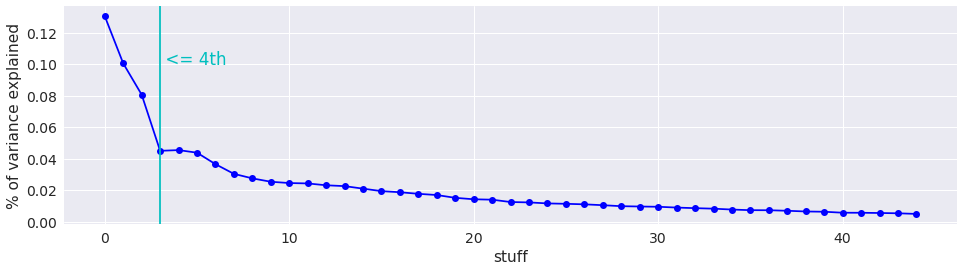

In [594]:
plt.figure(figsize = (16, 4))
plt.plot(var_ratio_df['var_ratio'], 'b-o')
plt.axvline(3, color = "c")
plt.text(3, 0.1, " <= 4th", color = "c")
plt.ylabel("% of variance explained")
plt.xlabel("stuff")
plt.show()

In [591]:
clust_svd = pd.DataFrame(tSVD_model.transform(clust_svd))
clust_svd.index = row_order
clust_svd.columns = 'svd_latent' + pd.Series(clust_svd.columns).map(str)

In [592]:
clust_svd['svd_grp'] = clust_svd.iloc[:, :4].idxmax(axis = 1, skipna = True)
clust_svd['svd_grp'] = clust_svd['svd_grp'].map(lambda x: int(re.sub("[^0-9]", "", x)))

In [593]:
clust_svd['svd_grp'].value_counts()

0    16398
3     1856
2      963
Name: svd_grp, dtype: int64

In [556]:
clust_dbscan = bk_topics.copy()
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', algorithm='auto')
clust_dbscan = pd.DataFrame(dbscan.fit_predict(clust_dbscan))
clust_dbscan.columns = ['dbscan_grouping']
clust_dbscan.set_index(row_order, inplace = True)
clust_dbscan.tail(1)

,,dbscan_grouping
bookid,userid,
17261174,1722508,0


In [557]:
clust_dbscan["dbscan_grouping"].value_counts()

0    19217
Name: dbscan_grouping, dtype: int64

In [ ]:
# start from here ==>

In [18]:
clust_km = bk_topics.copy()
kclust = KMeans(n_clusters = 4, random_state = 2320)
clust_km = pd.DataFrame(kclust.fit_predict(clust_km))
clust_km.columns = ['kmeans_grouping']
clust_km.set_index(row_order, inplace = True)
clust_km.tail(1)

,,kmeans_grouping
bookid,userid,
17261174,1722508,0


In [19]:
clust_km["kmeans_grouping"].value_counts()

0    10801
2     4772
1     3299
3      345
Name: kmeans_grouping, dtype: int64

In [20]:
clust_latent = bk_topics.copy()
clust_latent['nmf_grp'] = clust_latent.iloc[:, :4].idxmax(axis = 1, skipna = True)
clust_latent['nmf_grp'] = clust_latent['nmf_grp'].map(lambda x: int(re.sub("[^0-9]", "", x)))

In [21]:
clust_latent.tail(1)

,,nmf_latent0,nmf_latent1,nmf_latent2,nmf_latent3,nmf_latent4,nmf_latent5,nmf_latent6,nmf_latent7,nmf_latent8,nmf_latent9,nmf_latent10,nmf_latent11,nmf_latent12,nmf_latent13,nmf_latent14,nmf_latent15,nmf_latent16,nmf_latent17,nmf_latent18,nmf_latent19,nmf_latent20,nmf_latent21,nmf_latent22,nmf_latent23,nmf_latent24,nmf_latent25,nmf_latent26,nmf_latent27,nmf_latent28,nmf_latent29,nmf_latent30,nmf_latent31,nmf_latent32,nmf_latent33,nmf_latent34,nmf_latent35,nmf_latent36,nmf_latent37,nmf_latent38,nmf_latent39,nmf_latent40,nmf_latent41,nmf_latent42,nmf_latent43,nmf_latent44,nmf_latent45,nmf_latent46,nmf_latent47,nmf_latent48,nmf_latent49,nmf_grp
bookid,userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17261174,1722508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025052,0.000831,0.0,0.0,0.025048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002799,0.0,0.0,0.0,0.0,0.0,0.0,0.000947,0.054232,0.022637,0.018481,0.0,0.00004,0.0,0


In [22]:
clust_latent["nmf_grp"].value_counts()

0    9707
1    6484
2    2177
3     849
Name: nmf_grp, dtype: int64

In [23]:
book_meta = book_review.copy()[['bookid', 'userid', 'bk_title', "review_rating"]]
book_meta = book_meta.set_index(['bookid', 'userid'])

#clust_all = clust_latent.merge(clust_svd, left_index=True, right_index=True)
clust_all = clust_latent.merge(book_meta, left_index=True, right_index=True)
clust_all = clust_all.merge(sid_df, left_index=True, right_index=True)
#clust_all = clust_all.merge(clust_dbscan, left_index=True, right_index=True)
clust_all = clust_all.merge(clust_km, left_index=True, right_index=True)
clust_all.tail(1)

,,nmf_latent0,nmf_latent1,nmf_latent2,nmf_latent3,nmf_latent4,nmf_latent5,nmf_latent6,nmf_latent7,nmf_latent8,nmf_latent9,nmf_latent10,nmf_latent11,nmf_latent12,nmf_latent13,nmf_latent14,nmf_latent15,nmf_latent16,nmf_latent17,nmf_latent18,nmf_latent19,nmf_latent20,nmf_latent21,nmf_latent22,nmf_latent23,nmf_latent24,nmf_latent25,nmf_latent26,nmf_latent27,nmf_latent28,nmf_latent29,nmf_latent30,nmf_latent31,nmf_latent32,nmf_latent33,nmf_latent34,nmf_latent35,nmf_latent36,nmf_latent37,nmf_latent38,nmf_latent39,nmf_latent40,nmf_latent41,nmf_latent42,nmf_latent43,nmf_latent44,nmf_latent45,nmf_latent46,nmf_latent47,nmf_latent48,nmf_latent49,nmf_grp,bk_title,review_rating,sentiment_compound,sentiment_neg,sentiment_neu,sentiment_pos,kmeans_grouping
bookid,userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34861586,10992009,0.001414,0.000724,0.0,0.003628,0.0,0.0,0.0,0.032055,0.0,0.004565,0.0,0.0,0.000547,0.01121,0.006,0.0,0.0,0.0,0.0,0.004519,0.0,0.004499,0.006987,0.025455,0.0,0.013961,0.000399,0.0,0.0,0.0,0.009943,0.012538,0.000002,0.017427,0.003473,0.021912,0.004272,0.000785,0.00886,0.018421,0.001171,0.0,0.0,0.0,0.0,0.0,0.0,0.000147,0.016994,0.00166,3,Jackdaw,3,0.3116,0.128,0.773,0.099,0


In [16]:
pd.crosstab(clust_all['nmf_grp'], clust_all['review_rating'])

review_rating,1,2,3,4,5
nmf_grp,,,,,
0,475,737,1697,3354,3607
1,326,523,1041,2101,2565
2,62,191,417,789,760
3,18,32,166,349,291


In [632]:
pd.crosstab(clust_all['nmf_grp'], clust_all['kmeans_grouping'])

kmeans_grouping,0,1,2,3
nmf_grp,,,,
0,5955,62,4167,238
1,2836,3310,600,50
2,1918,33,396,16
3,776,19,44,41


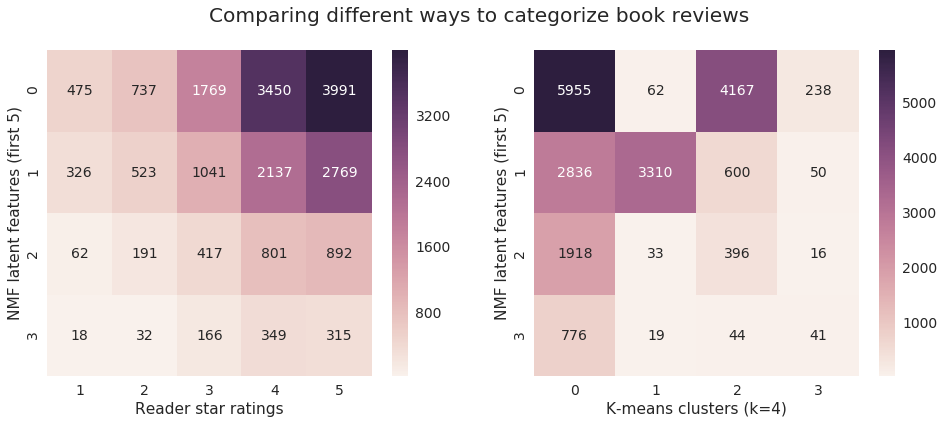

In [639]:
sns.set(font_scale=1.4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))#, sharey = True)
plt.suptitle("Comparing different ways to categorize book reviews")
comp_mx = pd.crosstab(clust_all['nmf_grp'], clust_all['review_rating'])
sns.heatmap(comp_mx, annot=True, fmt="d", annot_kws={"size": 14}, ax = ax1)
ax1.set_xlabel(r"Reader star ratings")
ax1.set_ylabel(r"NMF latent features (first 5)")

comp_mx = pd.crosstab(clust_all['nmf_grp'], clust_all['kmeans_grouping'])
sns.heatmap(comp_mx, annot=True, fmt="d", annot_kws={"size": 14}, ax = ax2)
ax2.set_ylabel(r"NMF latent features (first 5)")
ax2.set_xlabel(r"K-means clusters (k=4)")
plt.show()

In [640]:
cond = (clust_all['kmeans_grouping'] == 1) & (clust_all['nmf_grp'] == 1)
first_focus = clust_all.loc[cond]

In [641]:
first_focus = first_focus()

(3310, 105)

In [ ]:
cond2 = (clust_all['kmeans_grouping'] == 2) & (clust_all['nmf_grp'] == 0)

In [523]:
# clust_all["svd_grp"].value_counts()

0    15447
3     1642
6     1032
2      711
4      399
5      270
Name: svd_grp, dtype: int64

In [549]:
# comp_mx = pd.crosstab(clust_all['nmf_grp'], clust_all['dbscan_grouping'])
# comp_mx

dbscan_grouping,-1,0
nmf_grp,,
0,580,9061
1,0,6482
2,0,2210
3,0,791
4,0,697


In [643]:
kclust.cluster_centers_.shape

(4, 50)

In [644]:
bk_topics.shape

(19217, 50)

In [24]:
find_imp_words = nmf_model.inverse_transform(kclust.cluster_centers_)
find_imp_words = pd.DataFrame(find_imp_words).transpose()
find_imp_words.index = review_coll.columns

In [25]:
find_imp_words.tail(1)

,0,1,2,3
zon,0.00031,0.000373,0.000627,0.000035


In [668]:
# not very informative
for grp in range(4):
    top_wds = find_imp_words.sort_values(grp, ascending = False).index[:10]
    print("kmeans_grp", grp, top_wds)

kmeans_grp 0 Index(['story', 'sery', 'mor', 'real', 'lik', 'tim', 'just', 'lov', 'world',
       'did'],
      dtype='object')
kmeans_grp 1 Index(['thi book', 'real', 'lik', 'just', 'mor', 'story', 'did', 'sery',
       'read thi', 'lov'],
      dtype='object')
kmeans_grp 2 Index(['lik', 'ev', 'real', 'just', 'mor', 'ther', 'becaus', 'story', 'tim',
       'peopl'],
      dtype='object')
kmeans_grp 3 Index(['la', 'en', 'el', 'es', 'lo', 'se', 'las', 'par', 'en el', 'la la'], dtype='object')


In [26]:
find_imp_words['assign_words_to_kmeangrps'] = find_imp_words.idxmax(axis = 1)
find_imp_words.tail(10)

,0,1,2,3,assign_words_to_kmeangrps
zomby apocalyps,0.000296,0.000431,0.000700,0.000055,2
zomby book,0.000164,0.000381,0.000376,0.000037,1
zomby fict,0.000087,0.000108,0.000141,0.000011,2
zomby genr,0.000065,0.000089,0.000142,0.000005,2
zomby novel,0.000143,0.000120,0.000236,0.000004,2
zomby outbreak,0.000075,0.000098,0.000152,0.000012,2
zomby story,0.000102,0.000122,0.000164,0.000009,2
zomby vir,0.000093,0.000106,0.000141,0.000032,2
zomby war,0.000071,0.000096,0.000132,0.000007,2
zon,0.000310,0.000373,0.000627,0.000035,2


In [27]:
find_imp_words['assign_words_to_kmeangrps'].value_counts()

2    25054
1     4539
3     1087
0      512
Name: assign_words_to_kmeangrps, dtype: int64

In [28]:
for grp in range(4):
    cond = find_imp_words['assign_words_to_kmeangrps'] == grp
    temp = find_imp_words[cond]
    top_wds = list(temp.sort_values(grp, ascending = False).index[:10])
    print("K-Means", "cluster"+str(grp)+":", ", ".join(top_wds))

K-Means cluster0: hist, fun, rachel, harry, di, moor, laur, alex, thursday, jan
K-Means cluster1: thi book, did, sery, read thi, lov, auth, felt, thi sery, enjoy, review
K-Means cluster2: lik, ev, real, just, mor, ther, becaus, story, tim, peopl
K-Means cluster3: la, en, el, es, lo, se, las, par, en el, la la


In [49]:
def find_max(li):
    dict1 = {0: li[0], 1: li[1], 2: li[2], 3: li[3]}
    maxnum = max(li)
    if maxnum == None:
        return np.nan
    elif sum(li == maxnum) > 1:
        return np.nan
    else:
        for item in dict1.items():
            if item[1] == maxnum:
                return item

In [50]:
ct = clust_all.groupby(['bk_title', 'kmeans_grouping']).count()[['nmf_latent0']]
ct = ct.unstack()
ct.tail(5)

nmf_latent0                 
kmeans_grouping                           0     1     2    3
bk_title                                                    
Written in My Own Heart's Blood         1.0   2.0   2.0  NaN
Written in Red                          6.0  11.0  11.0  NaN
Y                                      56.0   1.0  30.0  1.0
Ysabel                                 12.0   2.0   5.0  NaN
Zoo City                               28.0   4.0  19.0  NaN

In [51]:
ct['grp'] = ct.apply(lambda x: find_max(x), axis=1)
ct['grp'].tail(1)

bk_title
Zoo City    (0, 28.0)
Name: grp, dtype: object

In [54]:
def separate_tup(tup, num):
    try:
        return tup[num]
    except:
        return np.nan

In [55]:
ct['bk_to_grp'] = ct['grp'].map(lambda x : separate_tup(x, 0))
#ct['bk_to_grpnum'] = ct['grp'].map(lambda x : separate_tup(x, 1))

In [59]:
ct.tail(1)

nmf_latent0                       grp bk_to_grp
kmeans_grouping           0    1     2   3                     
bk_title                                                       
Zoo City               28.0  4.0  19.0 NaN  (0, 28.0)       0.0

In [65]:
ct['bk_to_grp'].value_counts()

0.0    638
2.0     86
1.0     18
Name: bk_to_grp, dtype: int64

In [64]:
for grp in range(4):
    cond = ct['bk_to_grp'] == grp
    temp = ct[cond]
    top_bks = list(temp.sort_values('bk_to_grp', ascending = False).index[:5])
    print("K-Means", "cluster"+str(grp)+":", ", ".join(top_bks))

K-Means cluster0: 1634 The Baltic War, The Golem and the Jinni, The Giver, The Glass Books of the Dream Eaters, The Glass Magician
K-Means cluster1: A Conspiracy of Kings, And I Darken, The Winner's Crime, The Revenant of Thraxton Hall, The Lions of Al-Rassan
K-Means cluster2: 1Q84, The Book Thief, The Hunt, The Handmaid's Tale, The Golden Compass
K-Means cluster3: 


K-Means cluster0: The Golem and the Jinni, The Giver (638 books)
K-Means cluster1: A Conspiracy of Kings, And I Darken, The Winner's Crime (18 books)
K-Means cluster2: The Book Thief, The Handmaid's Tale, The Golden Compass (86 books)
K-Means cluster3: NA (0 books)

In [527]:
comp_mx = pd.crosstab(clust_all['nmf_grp'], clust_all['review_rating'])
comp_mx

review_rating,1,2,3,4,5
nmf_grp,,,,,
0,467,717,1626,3199,3456
1,325,511,1018,2053,2495
2,62,190,402,764,744
3,17,31,161,318,264
4,10,34,114,259,264


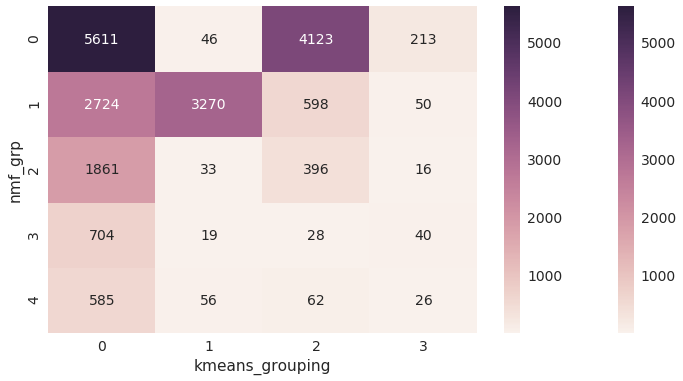

In [577]:
plt.figure(figsize = (12, 6))
sns.set(font_scale=1.4)
ax = sns.heatmap(comp_mx)
sns.heatmap(comp_mx, annot=True, fmt="d", annot_kws={"size": 14})

,,nmf_latent0,nmf_latent1,nmf_latent2,nmf_latent3,nmf_latent4,nmf_latent5,nmf_latent6,nmf_latent7,nmf_latent8,nmf_latent9,nmf_latent10,nmf_latent11,nmf_latent12,nmf_latent13,nmf_latent14,nmf_latent15,nmf_latent16,nmf_latent17,nmf_latent18,nmf_latent19,nmf_latent20,nmf_latent21,nmf_latent22,nmf_latent23,nmf_latent24,nmf_latent25,nmf_latent26,nmf_latent27,nmf_latent28,nmf_latent29,nmf_latent30,nmf_latent31,nmf_latent32,nmf_latent33,nmf_latent34,nmf_latent35,nmf_latent36,nmf_latent37,nmf_latent38,nmf_latent39,nmf_latent40,nmf_latent41,nmf_latent42,nmf_latent43,nmf_latent44,nmf_latent45,nmf_latent46,nmf_latent47,nmf_latent48,nmf_latent49,...,svd_latent4,svd_latent5,svd_latent6,svd_latent7,svd_latent8,svd_latent9,svd_latent10,svd_latent11,svd_latent12,svd_latent13,svd_latent14,svd_latent15,svd_latent16,svd_latent17,svd_latent18,svd_latent19,svd_latent20,svd_latent21,svd_latent22,svd_latent23,svd_latent24,svd_latent25,svd_latent26,svd_latent27,svd_latent28,svd_latent29,svd_latent30,svd_latent31,svd_latent32,svd_latent33,svd_latent34,svd_latent35,svd_latent36,svd_latent37,svd_latent38,svd_latent39,svd_latent40,svd_latent41,svd_latent42,svd_latent43,svd_latent44,svd_grp,bk_title,review_rating,sentiment_compound,sentiment_neg,sentiment_neu,sentiment_pos,dbscan_grouping,kmeans_grouping
bookid,userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34861586,10992009,0.001414,0.000724,0.0,0.003628,0.0,0.0,0.0,0.032055,0.0,0.004565,0.0,0.0,0.000547,0.01121,0.006,0.0,0.0,0.0,0.0,0.004519,0.0,0.004499,0.006987,0.025455,0.0,0.013961,0.000399,0.0,0.0,0.0,0.009943,0.012538,0.000002,0.017427,0.003473,0.021912,0.004272,0.000785,0.00886,0.018421,0.001171,0.0,0.0,0.0,0.0,0.0,0.0,0.000147,0.016994,0.00166,...,0.008186,0.010629,0.02785,-0.006742,0.00908,0.001911,-0.000739,0.002334,0.002979,0.006066,0.000842,-0.011075,-0.000221,-0.000178,0.011724,-0.008227,0.018272,0.002687,-0.005235,-0.002079,-0.006111,-0.005556,0.003494,0.017976,-0.008013,-0.000813,-0.002828,-0.008813,-0.007152,0.004437,0.010772,-0.002821,0.003076,-0.001162,-0.001795,-0.000142,0.003918,-0.000223,-0.00123,-0.00512,-0.00463,0,Jackdaw,3,0.3116,0.128,0.773,0.099,0,0


In [602]:
clust_all.shape

(20461, 105)

In [391]:
cond = (clust_all['nmf_grp'] == 2) & (clust_all['svd_grp'] == 3)
clust_all.loc[cond].head(5)

,,nmf_latent0,nmf_latent1,nmf_latent2,nmf_latent3,nmf_latent4,nmf_latent5,nmf_latent6,nmf_latent7,nmf_latent8,nmf_latent9,nmf_latent10,nmf_latent11,nmf_latent12,nmf_latent13,nmf_latent14,nmf_latent15,nmf_latent16,nmf_latent17,nmf_latent18,nmf_latent19,nmf_latent20,nmf_latent21,nmf_latent22,nmf_latent23,nmf_latent24,nmf_latent25,nmf_latent26,nmf_latent27,nmf_latent28,nmf_latent29,nmf_latent30,nmf_latent31,nmf_latent32,nmf_latent33,nmf_latent34,nmf_latent35,nmf_latent36,nmf_latent37,nmf_latent38,nmf_latent39,nmf_latent40,nmf_latent41,nmf_latent42,nmf_latent43,nmf_latent44,nmf_latent45,nmf_latent46,nmf_latent47,nmf_latent48,nmf_latent49,nmf_grp,svd_latent0,svd_latent1,svd_latent2,svd_latent3,svd_latent4,svd_latent5,svd_latent6,svd_latent7,svd_latent8,svd_latent9,svd_latent10,svd_latent11,svd_latent12,svd_latent13,svd_latent14,svd_latent15,svd_latent16,svd_latent17,svd_latent18,svd_latent19,svd_latent20,svd_latent21,svd_latent22,svd_latent23,svd_latent24,svd_latent25,svd_latent26,svd_latent27,svd_latent28,svd_latent29,svd_latent30,svd_latent31,svd_latent32,svd_latent33,svd_latent34,svd_latent35,svd_latent36,svd_latent37,svd_latent38,svd_latent39,svd_latent40,svd_latent41,svd_latent42,svd_latent43,svd_latent44,svd_grp,bk_title
bookid,userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
348,60231994,0.000000,0.008745,0.119221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000534,0.000415,0.000000,0.000000,0.031069,0.000000,0.000000,0.001106,0.000000,0.000000,0.000000,0.000000,0.033523,0.000000,0.042917,0.000000,0.009402,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.005826,0.000000,0.000000,0.000000,0.000000,0.000270,0.0,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2,0.035793,-0.029628,-0.001763,0.088014,-0.019077,-0.003503,-0.065079,0.010303,0.024561,0.017383,0.000557,0.004473,-0.007886,-0.004448,0.004453,-0.012770,0.030155,0.000892,-0.000627,0.000942,0.007715,0.008518,-0.002565,0.003466,0.000035,0.001193,0.009221,-0.001781,-0.021982,-0.003118,-0.001616,-0.024618,-0.006745,0.005409,-0.006764,-0.004393,-0.004568,0.004054,-0.004314,0.001287,0.004719,-0.000417,-0.003513,-0.004760,-0.002422,3,The Door Into Summer
703,63107263,0.021246,0.000000,0.075019,0.000000,0.000158,0.000000,0.000000,0.040309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000982,0.106571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000221,0.014344,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.006295,0.000000,0.000000,0.000000,0.000000,0.012954,0.0,0.000265,0.000314,0.000000,0.000000,0.000000,0.000352,0.000000,0.000000,0.0,0.000000,2,0.042358,-0.046428,-0.002654,0.077118,-0.014195,-0.002944,-0.017436,-0.019943,0.007246,-0.051772,0.010196,0.006065,0.022630,-0.024777,-0.010349,0.055450,0.001491,-0.008053,0.014793,-0.006158,-0.024754,-0.010629,0.001540,0.005961,0.001377,-0.001277,0.003860,0.002296,-0.007031,-0.001110,-0.001136,-0.009007,-0.001525,0.001039,0.003550,0.002806,-0.008246,0.004619,0.007191,-0.003353,0.004234,-0.003151,-0.005187,0.000110,-0.001174,3,The Plot Against America
816,304412,0.008116,0.003183,0.084269,0.002887,0.000950,0.000376,0.000544,0.000000,0.000414,0.000000,0.000000,0.000119,0.000017,0.004170,0.000000,0.001676,0.000422,0.000000,0.000524,0.002813,0.005025,0.001479,0.000400,0.003981,0.000000,0.003869,0.0,0.012227,0.0,0.00377,0.000120,0.000000,0.000036,0.000000,0.000000,0.003673,0.013838,0.002089,0.000803,0.0,0.012817,0.000293,0.001662,0.000351,0.003556,0.005665,0.008314,0.000000,0.0,0.001351,2,0.025461,-0.026852,-0.001165,0.054822,-0.013412,-0.002135,-0.047216,0.008206,0.018488,0.016405,-0.001356,0.002415,-0.002434,-0.003666,0.000635,-0.001419,-0.001976,-0.000493,0.004562,0.002838,-0.002190,-0.003843,0.004285,0.008444,0.000351,-0.001675,-0.001773,-0.000025,0.003533,0.000207,0.000662,0.005564,0.007124,-0.003698,-0.009771,0.002064,-0.003590,0.002270,0.000796,0.002004,-0.000668,0.003706,0.000941,-

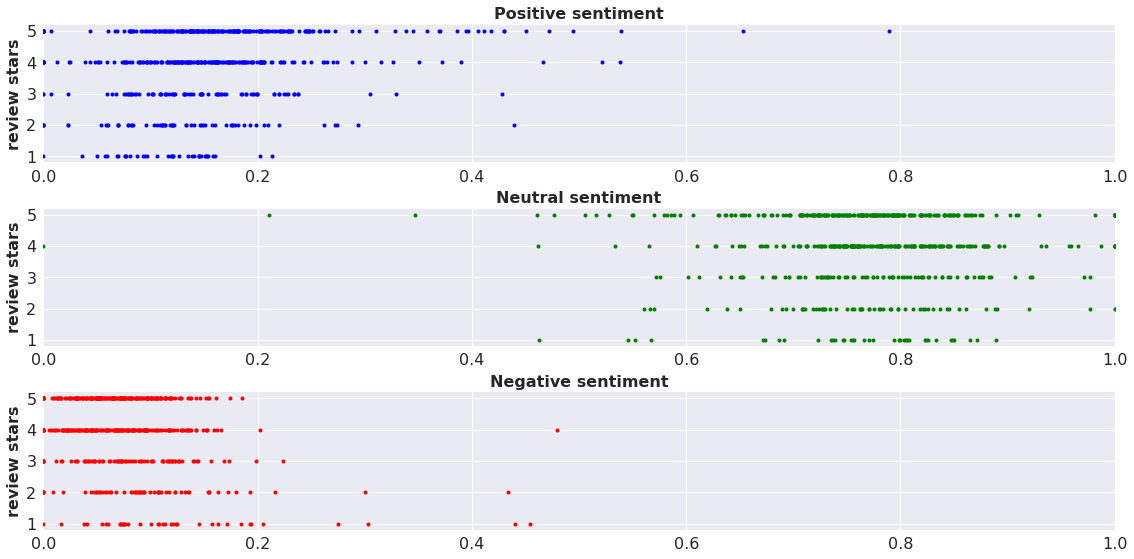

In [513]:
sample = np.random.choice(range(len(clust_all)), size=600, replace=False)
sample_df = clust_all.iloc[sample]
plt.subplots(3, 1, figsize = (16, 8))
plt.tight_layout(pad = 2.5)
plt.subplot(3, 1, 1)
plt.plot(sample_df['sentiment_pos'], sample_df['review_rating'], "bo", markersize = 4)
plt.title("Positive sentiment", fontsize = 16, fontweight = "bold")
plt.ylabel("review stars", fontsize = 16, fontweight = "bold")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim([0, 1])
plt.subplot(3, 1, 2)
plt.plot(sample_df['sentiment_neu'], sample_df['review_rating'], "go", markersize = 4)
plt.title("Neutral sentiment", fontsize = 16, fontweight = "bold")
plt.ylabel("review stars", fontsize = 16, fontweight = "bold")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim([0, 1])
plt.subplot(3, 1, 3)
plt.plot(sample_df['sentiment_neg'], sample_df['review_rating'], "ro", markersize = 4)
plt.title("Negative sentiment", fontsize = 16, fontweight = "bold")
plt.ylabel("review stars", fontsize = 16, fontweight = "bold")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim([0, 1])
plt.show()